Every model we have seen  so far  has assumed that each predictor has an independent association with the mean of the outcome.
What if we want to allow the association to be conditional?
What if we want to allow the association to be conditional?
For example, in the primate milk data from the previous chapters, suppose the relationship
between milk energy and brain size varies by taxonomic group (ape, monkey, prosimian).
This is the same as suggesting that the influence of brain size on milk energy is conditional
on taxonomic group. The linear models of previous chapters cannot address this question.


To model deeper conditionality—where the importance of one predictor depends upon another predictor—we need <b>interaction</b> (also known as <b>moderation</b>). Interaction is a kind of conditioning, a way of allowing parameters (really their posterior distributions) to be conditional on further aspects of the data. 


The simplest kind of interaction, a linear interaction, is built by extending the linear modeling strategy to parameters within the linear
model.It is descriptive, but very powerful.




Models that allow for complex interactions are easy to fit to data. But they can be considerably
harder to understand. And so we  will spend this chapter reviewing simple interaction
effects: how to specify them, how to interpret them, and how to plot them.
The chapter starts with a case of an interaction between a single <b>categorical</b> (indicator) variable and a
single continuous variable. In this context, it is easy to appreciate the sort of hypothesis that
an interaction allows for. Then the chapter moves on to more complex interactions between
multiple continuous predictor variables. These are harder. In every section of this chapter,
the model predictions are visualized, averaging over uncertainty in parameters.

In [8]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from scipy import stats

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=FutureWarning)


In [9]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # set credible interval for entire notebook
az.rcParams["stats.information_criterion"] = "waic"  # set information criterion to use in `compare`
az.rcParams["stats.ic_scale"] = "deviance"  # set information criterion scale
np.random.seed(0)


In [10]:
d = pd.read_csv("Data/rugged.csv", delimiter=";")

# make log version of the outcome
d["log_gdp"] = np.log(d["rgdppc_2000"])

# extract countries with GDP data
dd = d.dropna(subset=["log_gdp"])

# rescale variables
dd["log_gdp_std"] = dd["log_gdp"] / dd["log_gdp"].mean()
dd["rugged_std"] = dd["rugged"] / dd["rugged"].max()

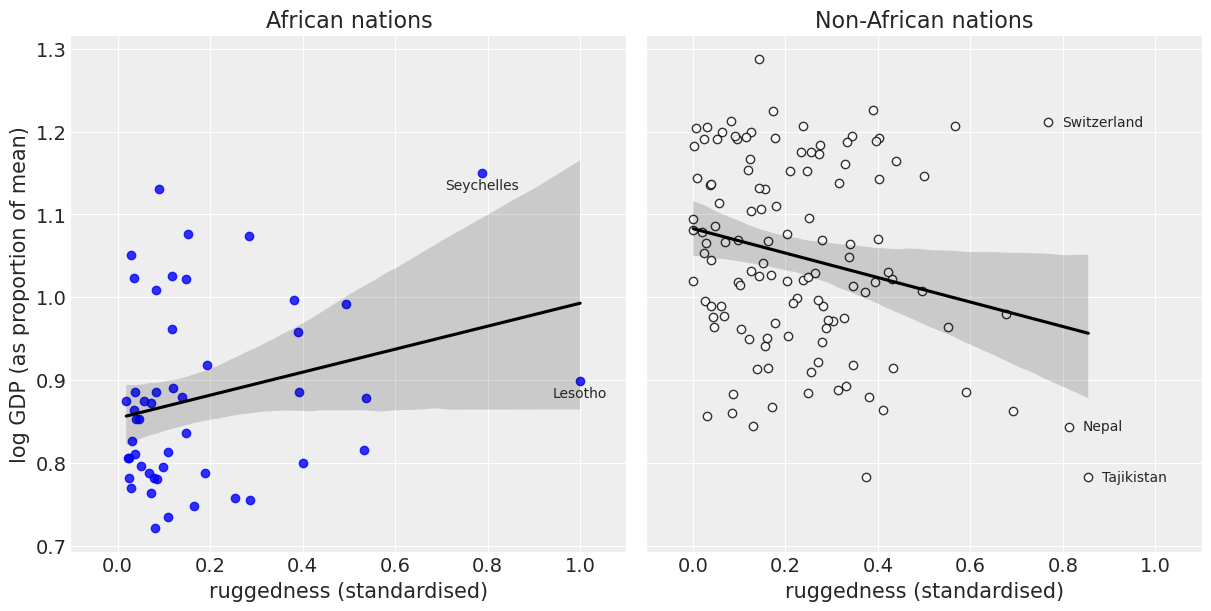

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.regplot(
    dd.loc[dd["cont_africa"] == 1]["rugged_std"],
    dd.loc[dd["cont_africa"] == 1]["log_gdp_std"],
    scatter_kws={"color": "b"},
    line_kws={"color": "k"},
    ax=axs[0],
)
sns.regplot(
    dd.loc[dd["cont_africa"] == 0]["rugged_std"],
    dd.loc[dd["cont_africa"] == 0]["log_gdp_std"],
    scatter_kws={"edgecolor": "k", "facecolor": "w"},
    line_kws={"color": "k"},
    ax=axs[1],
)

axs[0].set_ylabel("log GDP (as proportion of mean)")
axs[1].set_ylabel("")
axs[0].set_title("African nations")
axs[1].set_title("Non-African nations")

# label countries
for _, africa in dd.loc[(dd["rugged_std"] > 0.7) & (dd["cont_africa"] == 1)].iterrows():
    axs[0].text(
        africa["rugged_std"],
        africa["log_gdp_std"] - 0.02,
        africa["country"],
        ha="center",
    )

for _, non_africa in dd.loc[(dd["rugged_std"] > 0.7) & (dd["cont_africa"] == 0)].iterrows():
    axs[1].text(
        non_africa["rugged_std"] + 0.03,
        non_africa["log_gdp_std"],
        non_africa["country"],
        va="center",
    )

for ax in axs:
    ax.set_xlim(-0.1, 1.1)
    ax.set_xlabel("ruggedness (standardised)")

Africa is special. The second largest continent, it is the most culturally and genetically
diverse. Africa has about 3 billion fewer people than Asia, but it has just as many living languages.
Africa is so genetically diverse that most of the genetic variation outside of Africa
is just a subset of the variation within Africa. Africa is also geographically special, in a puzzling
way: Bad geography tends to be related to bad economies outside of Africa, but African
economies may actually benefit from bad geography. 


What is going on in this figure? It makes sense that ruggedness is associated with poorer
countries, in most of the world. Rugged terrain means transport is difficult. Which means
market access is hampered. Which means reduced gross domestic product. So the reversed relationship within Africa is puzzling. Why should difficult terrain be associated with higher
GDP per capita?

If this relationship is at all causal, it may be because rugged regions of Africa were protected
against the Atlantic and Indian Ocean slave trades. Slavers preferred to raid easily
accessed settlements, with easy routes to the sea. Those regions that suffered under the slave
trade understandably continue to suffer economically, long after the decline of slave-trading
markets. However, an outcome like GDP has many influences, and is furthermore a strange
measure of economic activity. And ruggedness is correlated with other geographic features,
like coastlines, that also influence the economy. So it is hard to be sure what’s going on here.


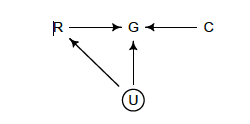

The causal hypothesis, in DAG form, might be as above, where R is terrain ruggedness, G is GDP, C is continent, and U is some set of unobserved confounds (like distance to coast). Let’s ignore U for now. 

Focus instead on the implication that R and C both influence G. This could mean that they are independent influences or rather that they interact
(one moderates the influence of the other).

The DAG does not display an interaction. That’s
because DAGs do not specify how variables combine to influence other variables. The DAG
above implies only that there is some function that uses R and C to generate G. In typical
notation, G = f(R, C).


So we need a statistical approach to judge different propositions for f(R, C). How do we
make a model that produces the conditionality in the graph above (gdp vs ruggedness).We could cheat by splitting 
the data into two data frames, one for Africa and one for all the other continents. But it’s not
a good idea to split the data in this way. Here are four reasons



good idea to split the data in this way. Here are four reasons.
First, there are usually some parameters, such as σ, that the model says do not depend
in any way upon continent. By splitting the data table, you are hurting the accuracy of the estimates
for these parameters, because you are essentially making two less-accurate estimates
instead of pooling all of the evidence into one estimate. In effect, you have accidentally assumed
that variance differs between African and non-African nations. Now, there’s nothing
wrong with that sort of assumption. But you want to avoid accidental assumptions

Second, in order to acquire probability statements about the variable you used to split
the data, cont_africa in this case, you need to include it in the model.
Otherwise, you
have only the weakest sort of statistical argument. 
<b>Isn’t there uncertainty about the predictive
value of distinguishing between African and non-African nations? </b>
Of course there is. Unless
you analyze all of the data in a single model, you can’t easily quantify that uncertainty. If you
just let the posterior distribution do the work for you, you’ll have a useful measure of that
uncertainty.

Third, we may want to use information criteria or another method to <b>compare models</b>.
In order to compare a model that treats all continents the same way to a model that allows
different slopes in different continents, we need models that use all of the same data . This means we can’t split the data, but have to make the model split the data.

Fourth, once you begin using multilevel models , you’ll see that there are
advantages to borrowing information across categories like “Africa” and “not Africa.” This is
especially true when sample sizes vary across categories, such that overfitting risk is higher
within some categories. In other words, what we <b>learn about ruggedness outside of Africa
should have some effect on our estimate within Africa,</b> and visa versa.
When we split the data, this borrowing is impossible.

<h2>Making  model</h2>. Let’s see how to recover the reversal of slope, within a single
model. 

We’ll begin by fitting a single model to all the data, ignoring continent. This will let
us think through the model structure and priors before facing the devil of interaction. 

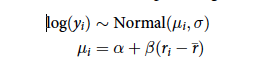

In [16]:
with pm.Model() as m_8_1:
    a = pm.Normal("a", 1, 1)
    b = pm.Normal("b", 0, 1)

    mu = a + b * (dd["rugged_std"] - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, shape=dd.shape[0])
    m_8_1_prior = pm.sample_prior_predictive()


Remember that using ¯r just makes it easier to assign a prior to the intercept α.

The hard thinking here comes when we specify priors. If you are like me, you don’t
have much scientific information about plausible associations between log GDP and terrain
ruggedness. But even when we don’t know much about the context, the measurements themselves
constrain the priors in useful ways.

The scaled outcome and predictor will make this
easier. Consider first the intercept, α, defined as the log GDP when ruggedness is at the
sample mean. So it must be close to 1, because we scaled the outcome so that the mean is 1.





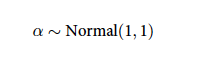

But what about the standard deviation? Let’s start with a guess at 1:
β ∼ Normal(0, 1)
We’ll evaluate this guess by simulating prior predictive distributions. The last thing we need
is a prior for σ. Let’s assign something very broad, σ ∼ Exponential(1).

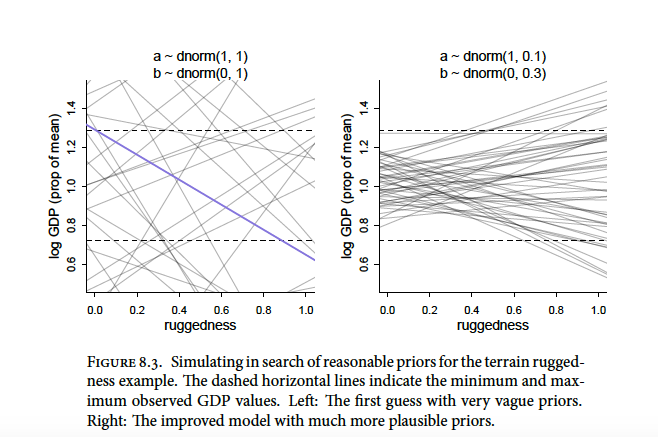

In [17]:
np.sum(np.abs(m_8_1_prior["b"]) > 0.6) / len(m_8_1_prior["b"])

0.516

In [18]:
with pm.Model() as m_8_1t:
    a = pm.Normal("a", 1, 0.1)
    b = pm.Normal("b", 0, 0.3)

    mu = a + b * (dd["rugged_std"] - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"])

    m_8_1t_trace = pm.sample()

    m_8_1t_prior = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 37 seconds.


In [19]:
az.summary(m_8_1t_trace, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
a,1.00,0.01,0.98,1.02
b,0.00,0.06,-0.09,0.09
sigma,0.14,0.01,0.13,0.15


Really no overall association between terrain ruggedness and log GDP

Nations in Africa will get one intercept and those outside
Africa another. This is what μi looks like now: 

μi =  α cid[i] +  β(ri −¯r)

where cid is an index variable, continent ID. It takes the value 1 for African nations and 2 for
all other nations.

In [20]:
cid = pd.Categorical(dd["cont_africa"])

In [21]:
with pm.Model() as m_8_2:
    a = pm.Normal("a", 1, 0.1, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3)

    mu = a[cid] + b * (dd["rugged_std"] - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"])

    m_8_2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 24 seconds.


In [22]:
az.compare({"m_8_1t": m_8_1t_trace, "m_8_2": m_8_2_trace})



/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:144: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:1454: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_8_2,0,-252.093,4.23114,0,0.968436,14.8755,0,True,deviance
m_8_1t,1,-188.551,2.73726,63.5419,0.0315642,12.9806,14.7088,False,deviance


m8.2 gets all the model weight. And while the standard error of the difference in WAIC is 15,
the difference itself is 64. So the continent variable seems to be picking up some important
association in the sample

In [23]:
az.summary(m_8_2_trace, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
a[0],1.05,0.01,1.03,1.07
a[1],0.88,0.02,0.85,0.91
b,-0.05,0.05,-0.12,0.03
sigma,0.11,0.01,0.10,0.12


The parameter a[0] is the intercept for African nations. It seems reliably lower than a[1].
The posterior contrast between the two intercepts is:

In [24]:
with m_8_2:
    m_8_2_posterior = pm.sample_posterior_predictive(m_8_2_trace, vars=[a, b, sigma])

diff_a0_a1 = m_8_2_posterior["a"][:, 1] - m_8_2_posterior["a"][:, 0]

az.hdi(diff_a0_a1)

array([-0.19799283, -0.13735134])

difference is reliably below zero.
Let’s plot the posterior predictions for m8.2, so you can see how, despite it’s predictive
superiority to m8.1, it still doesn’t manage different slopes inside and outside of Africa. To
sample from the posterior and compute the predicted means and intervals for both African
and non-African nations:

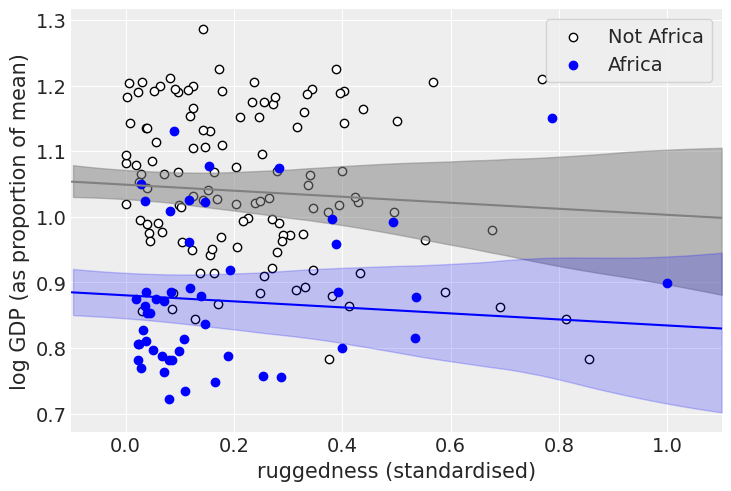

In [17]:
fig, ax = plt.subplots()

rugged_plot = np.linspace(-0.1, 1.1)

ax.scatter(
    dd.loc[cid == 0, "rugged_std"],
    dd.loc[cid == 0, "log_gdp_std"],
    label="Not Africa",
    facecolor="w",
    lw=1,
    edgecolor="k",
)

pred0 = m_8_2_posterior["a"][:, 0] + rugged_plot.reshape(-1, 1) * m_8_2_posterior["b"]
ax.plot(rugged_plot, pred0.mean(1), color="grey")
az.plot_hdi(rugged_plot, pred0.T, color="grey", hdi_prob=0.97, ax=ax)

ax.scatter(
    dd.loc[cid == 1, "rugged_std"],
    dd.loc[cid == 1, "log_gdp_std"],
    label="Africa",
    color="b",
)
pred1 = m_8_2_posterior["a"][:, 1] + rugged_plot.reshape(-1, 1) * m_8_2_posterior["b"]
ax.plot(rugged_plot, pred1.mean(1), color="b")
az.plot_hdi(rugged_plot, pred1.T, color="b", hdi_prob=0.97, ax=ax, fill_kwargs={"alpha": 0.2})

ax.legend(frameon=True)

ax.set_xlim(-0.1, 1.1)
ax.set_xlabel("ruggedness (standardised)")
ax.set_ylabel("log GDP (as proportion of mean)");


All including a dummy variable for African nations
has done is allow the model to predict a lower mean for African nations. It can’t do anything
to the slope of the line. The fact that WAIC tells you that the model with the dummy variable
is hugely better only indicates that African nations on average do have lower GDP. It’s still a
bad model

 Make the slope conditional on continent

In [25]:
with pm.Model() as m_8_3:
    a = pm.Normal("a", 1, 0.1, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3, shape=cid.categories.size)

    mu = a[cid] + b[cid] * (dd["rugged_std"] - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"])

    m_8_3_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.


In [26]:
az.summary(m_8_3_trace, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
a[0],1.05,0.01,1.03,1.07
a[1],0.89,0.02,0.86,0.91
b[0],-0.14,0.06,-0.23,-0.06
b[1],0.13,0.07,0.02,0.25
sigma,0.11,0.01,0.10,0.12


In [ ]:
How much does allowing the slope to vary improve expected prediction? 

In [27]:


az.compare({"m_8_1t": m_8_1t_trace, "m_8_2": m_8_2_trace, "m_8_3": m_8_3_trace}, ic="loo")



/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:144: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_8_3,0,-259.437,4.84877,0,0.899169,14.5528,0,False,deviance
m_8_2,1,-252.072,4.24162,7.36467,0.100831,14.881,6.46907,False,deviance
m_8_1t,2,-188.536,2.74495,70.901,0,12.982,14.814,False,deviance


Model family m8.3 has more than 87% of the model weight. That’s very strong support for
including the interaction effect, if prediction is our goal. But the modicum of weight given
to m8.2 suggests that the posterior means for the slopes in m8.3 are a little overfit. And the
standard error of the difference in PSIS between the top two models is almost the same as
the difference itself. If you plot PSIS Pareto k values for m8.3, you’ll notice some influential
countries. This is possibly a good context for robust regression, like the Student-t regression
<h2>plotting the model</h2>

In [28]:
with m_8_3:
    m_8_3_posterior = pm.sample_posterior_predictive(m_8_3_trace, var_names=["a", "b"])

Text(0, 0.5, 'log GDP (as proportion of mean)')

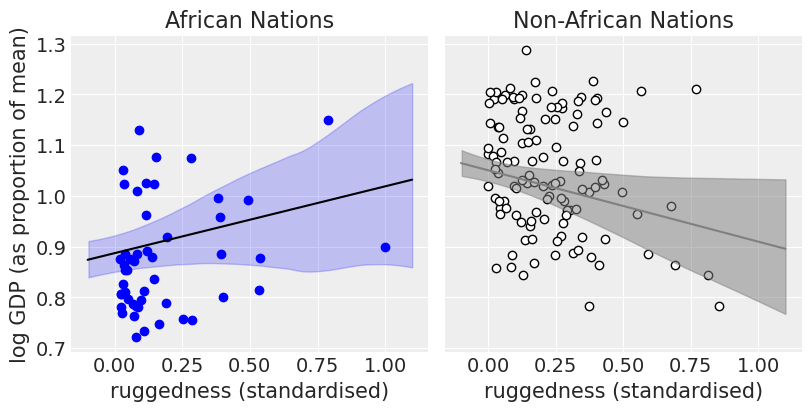

In [29]:
_, axs = plt.subplots(
    1,
    2,
    figsize=[8, 4],
    sharey=True,
    constrained_layout=True,
)

ax1, ax0 = axs

rugged_plot = np.linspace(-0.1, 1.1)

ax0.scatter(
    dd.loc[cid == 0, "rugged_std"],
    dd.loc[cid == 0, "log_gdp_std"],
    label="Not Africa",
    facecolor="w",
    lw=1,
    edgecolor="k",
)
# calculating predicted manually because this is a pain with categorical variabiles in PyMC3
pred0 = m_8_3_posterior["a"][:, 0] + rugged_plot.reshape(-1, 1) * m_8_3_posterior["b"][:, 0]
ax0.plot(rugged_plot, pred0.mean(1), color="grey")
az.plot_hdi(rugged_plot, pred0.T, color="grey", hdi_prob=0.97, ax=ax0)
ax0.set_title("Non-African Nations")

ax1.scatter(
    dd.loc[cid == 1, "rugged_std"],
    dd.loc[cid == 1, "log_gdp_std"],
    label="Africa",
    color="b",
)
# calculating predicted manually because this is a pain with categorical variabiles in PyMC3
pred1 = m_8_3_posterior["a"][:, 1] + rugged_plot.reshape(-1, 1) * m_8_3_posterior["b"][:, 1]
ax1.plot(rugged_plot, pred1.mean(1), color="k")
az.plot_hdi(
    rugged_plot,
    pred1.T,
    color="blue",
    hdi_prob=0.97,
    ax=ax1,
    fill_kwargs={"alpha": 0.2},
)
ax1.set_title("African Nations")


ax.set_xlim(-0.1, 1.1)
ax0.set_xlabel("ruggedness (standardised)")
ax1.set_xlabel("ruggedness (standardised)")
ax0.set_ylabel("")
ax1.set_ylabel("log GDP (as proportion of mean)")

A simple interaction model contains two symmetrical interpretations. Absent some other information,
outside the model, there’s no logical basis for preferring one over the other. Consider for example the GDP and terrain ruggedness problem. The interaction there has two equally
valid phrasings.

(1) How much does the association between ruggedness and log GDP depend upon
whether the nation is in Africa?

(2) How much does the association of Africa with log GDP depend upon ruggedness?

While these two possibilities sound different to most humans, your model thinks they are
identical.
In this section, we’ll examine this fact, first mathematically. Then we’ll plot the ruggedness
and GDP example again, but with the reverse phrasing—the association between Africa
and GDP depends upon ruggedness.

Consider yet again the model for μi:
    
     μi = αcid[i] + βcid[i](ri −¯r)
        
The interpretation previously has been that the <b>slope is conditional on continent</b>. But it’s also
fine to say that the intercept is conditional on ruggedness. It’s easier to see this if we write
the above expression another way:
μi = (2 − cidi)(α1 + β1(ri −¯r))  +(cidi − 1)(α2 + β2(ri −¯r)) 

 Now if we imagine switching a  nation to Africa, in order to know what this does for the prediction, we have to know the
ruggedness.

Plot the reverse interpretation: The association of being in Africa with log GDP depends upon terrain ruggedness. What we’ll do is compute the difference between a nation in Africa and outside Africa, holding its ruggedness constant.

(0.0, 1.0)

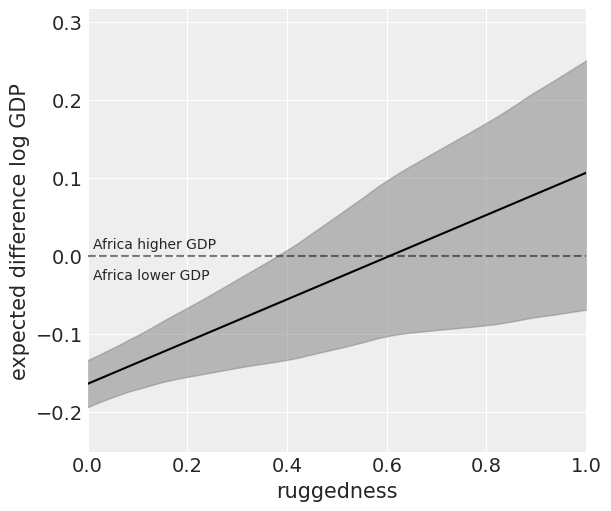

In [23]:
fig, ax = plt.subplots(figsize=(6, 5))

rugged_plot = np.linspace(-0.1, 1.1)

delta = pred1 - pred0  # using 'pred' from above

ax.plot(rugged_plot, delta.mean(1), c="k")
az.plot_hdi(rugged_plot, delta.T, ax=ax, color="grey")

ax.axhline(0, ls="dashed", zorder=1, color=(0, 0, 0, 0.5))
ax.text(0.01, 0.01, "Africa higher GDP")
ax.text(0.01, -0.03, "Africa lower GDP")

ax.set_xlabel("ruggedness")
ax.set_ylabel("expected difference log GDP")
ax.set_xlim(0, 1)

This plot is counter-factual. There is no raw data here.Instead we are seeing through the model’s eyes and imagining comparisons between identical nations inside and outside Africa, as if we could independently manipulate continent
and also terrain ruggedness. 
Below the horizontal dashed line, African nations have lower expected GDP. This is the case for most terrain ruggedness values.

But at the highest ruggedness values, a nation is possibly better off inside Africa than outside it.


Really it is hard to find any reliable difference inside and outside Africa, at high ruggedness values. 
It is only in smooth nations that being in Africa is a liability for the economy.

This perspective on the GDP and terrain ruggedness is completely consistent with the
previous perspective. 
It’s simultaneously true in these data (and with this model) that (1) the
influence of ruggedness depends upon continent and (2) the influence of continent depends
upon ruggedness. 
Indeed, something is gained by looking at the data in this symmetrical
perspective. Just inspecting the first view of the interaction, it’s not obvious
that African nations are on average nearly always worse off. 
It’s just at very high values
of rugged that nations inside and outside of Africa have the same expected log GDP. This
second way of plotting the interaction makes this clearer.

<h1>Continous interactions</h1>

T interaction effects are difficult to interpret. They are nearly impossible to interpret, using only posterior means and standard deviations.

Once interactions exist, multiple parameters are always in play at the same time. It is hard enough
with the simple, categorical interactions from the terrain ruggedness example. Once we start
modeling interactions among more than one continuous variables, it gets much harder.

It’s one thing to make a slope conditional upon a category. In such a context, the model reduces
to estimating a different slope for each category. But it’s quite a lot harder to understand that
a slope varies in a continuous fashion with a continuous variable. Interpretation is much
harder in this case, even though the mathematics of the model are essentially the same as in
the categorical case.

<h2>A winter flower</h2> . The data in this example are sizes of blooms from beds of tulips
grown in greenhouses, under different soil and light conditions.

In [33]:
d = pd.read_csv("Data/tulips.csv", delimiter=";")
d.head()

,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


The blooms column will be our outcome—what we wish to predict. The water and shade
columns will be our predictor variables. water indicates one of three ordered levels of soil
moisture, from low (1) to high (3). shade indicates one of three ordered levels of light exposure,
from high (1) to low (3). The last column, bed, indicates a cluster of plants from the
same section of the greenhouse.


Since both light and water help plants grow and produce blooms, it stands to reason that
the independent effect of each will be to produce bigger blooms. But we’ll also be interested
in the interaction between these two variables. In the absence of light, for example, it’s hard
to see how water will help a plant—photosynthesis depends upon both light and water.

Likewise, in the absence of water, sunlight does a plant little good. One way to model such an
interdependency is to use an interaction effect.
In the absence of a good mechanistic model
of the interaction, one that uses a theory about the plant’s physiology to hypothesize the
functional relationship between light and water, then a simple linear two-way interaction is
a good start. But ultimately it’s not close to the best that we could do.



focus on just two models:
(1) the model with both water
and shade but no interaction and 


(2) the model that also contains the interaction of water
with shade.



The causal scenario is simply that water (W) and shade (S) both influence blooms (B):
W → B ← S.

As before, this DAG doesn’t tell us the function through which W and S jointly
influence B, B = f(W, S). 

The convention is to do something much simpler. We’ll start simple.
The first model, containing no interaction at all (only “main effects”), begins this way:
Bi ∼ Normal(μi, σ)

μi = α + βW(Wi − ¯ W) + βS(Si − ¯S)

In [34]:
d["blooms_std"] = d["blooms"] / d["blooms"].max()
d["water_cent"] = d["water"] - d["water"].mean()
d["shade_cent"] = d["shade"] - d["shade"].mean()

Now blooms_std ranges from 0 to 1, and both water_cent and shade_cent range from −1 to 1. I’ve scaled blooms by its maximum observed value, for three reasons. 
First, the large values on the raw scale will make optimization difficult. 
Second, it will be easier to assign a reasonable prior this way. 
Third, we don’t want to standardize blooms, because zero is a meaningful boundary we want to preserve.

Centering the prior for α at 0.5 implies that, when both water and shade are at their mean
values, the model expects blooms to be halfway to the observed maximum. The two slopes
are centered on zero, implying no prior information about direction

In [35]:
a = stats.norm.rvs(0.5, 1, 10000)

sum((a < 0) | (a > 1)) / len(a)

#The prior bounds on the parameters come from the prior standard deviations, all set to
# 1 here. These are surely too broad. The intercept α must be greater than zero and less than
# one, for example. But this prior assigns most of the probability outside that range:

0.6261

In [36]:
#but if change the std to 0.25

a = stats.norm.rvs(0.5, 0.25, 10000)
sum((a < 0) | (a > 1)) / len(a)

0.0434

What about those slopes? 

What would a very strong effect of water and shade look like?

How big could those slopes be in theory? 

The range of both water and shade is 2  —from −1 to 1 is 2 units.
To take us from the theoretical minimum of zero blooms on one end to the observed maximum of 1—a range of 1 unit—on the other would require a slope of 0.5 from either variable—0.5×2 = 1. 

So if we assign a standard deviation of 0.25 to each, then
95% of the prior slopes are from −0.5 to 0.5, so either variable could in principle account
for the entire range, but it would be unlikely.
Remember, the goals here are to assign weakly
informative priors to discourage overfitting—impossibly large effects should be assigned low
prior probability—and also to force ourselves to think about what the model means.

In [37]:
with pm.Model() as flowerindependent:
    a = pm.Normal("a", 0.5, 0.25)
    bw = pm.Normal("bw", 0, 0.25)
    bs = pm.Normal("bs", 0, 0.25)

    mu = a + bw * d["water_cent"] + bs * d["shade_cent"]
    sigma = pm.Exponential("sigma", 1)

    blooms_std = pm.Normal("blooms_std", mu, sigma, observed=d["blooms_std"])

    flowerindependent_trace = pm.sample()
    flowerindependent_post = pm.sample_posterior_predictive(  flowerindependent_trace, var_names=["a", "bw", "bs"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bs, bw, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.


<h2>İnteraction model</h2>

In the previous example, terrain ruggedness, we made a slope conditional on the value of
a category.. When there are, in principle, an infinite number of categories, then it’s harder. In
this case, the “categories” of shade and water are, in principle, infinite and ordered. We only
observed three levels of water, but the model should be able to make a prediction with a water
level intermediate between any two of the observed ones. With continuous interactions, the
problem isn’t so much the infinite part but rather the ordered part. Even if we only cared
about the three observed values, we’d still need to preserve the ordering, which is bigger
than which

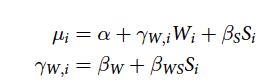

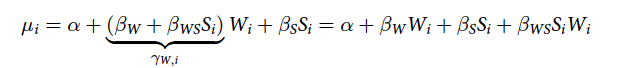

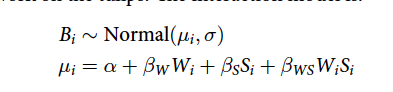

The last thing we need is a prior for this new interaction parameter, βWS. This is hard, because
it does not have clear natural meaning. Still, implied predictions help.
Suppose the strongest plausible interaction is one in which high enough shade makes water have zero effect. That implies:

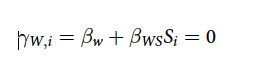

If we set Si = 1 (the maximum in the sample), then this means the interaction needs to be the
same magnitude as the main effect, but reversed: βWS = −βW. That is largest conceivable
interaction. So if we set the prior for βWS to have the same standard deviation as βW, maybe
that isn’t ridiculous.

In [38]:
with pm.Model() as flowerinteraction:
    a = pm.Normal("a", 0.5, 0.25)
    bw = pm.Normal("bw", 0, 0.25)
    bs = pm.Normal("bs", 0, 0.25)
    bws = pm.Normal("bws", 0, 0.25)

    mu = a + bw * d["water_cent"] + bs * d["shade_cent"] + bws * d["water_cent"] * d["shade_cent"]
    sigma = pm.Exponential("sigma", 1)

    blooms_std = pm.Normal("blooms_std", mu, sigma, observed=d["blooms_std"])

    flowerinteraction_trace = pm.sample()
    flowerinteraction_post = pm.sample_posterior_predictive(flowerinteraction_trace, var_names=["a", "bw", "bs", "bws"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bws, bs, bw, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.


let’s figure out how to plot these creatures.

the strategy. We want each plot to show the bivariate relationship between water and blooms,
as predicted by the model.
Each plot will plot predictions for a different value of shade.

For this example, it is easy to pick which three values of shade to use, because there are only
three values: −1, 0, and 1. 

But more generally, you might use a representative low value, the
median, and a representative high value.


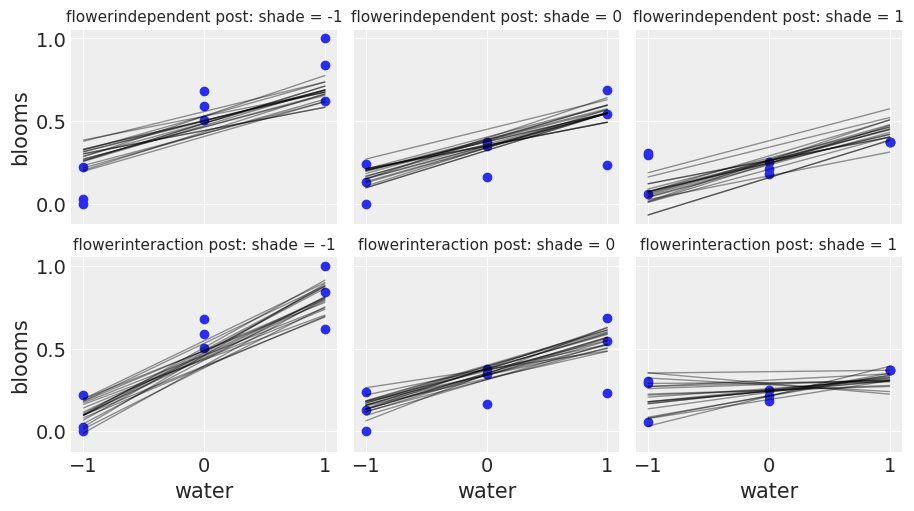

In [39]:
_, axs = plt.subplots(2, 3, figsize=[9, 5], sharey=True, sharex=True, constrained_layout=True)

n_lines = 20
pred_x = np.array([-1, 1])

for i, shade in enumerate([-1, 0, 1]):
    ind = d.shade_cent == shade
    for ax in axs[:, i]:
        ax.scatter(d.loc[ind, "water_cent"], d.loc[ind, "blooms_std"])
    # top row, m_8_4
    ax = axs[0, i]
    ax.set_title(f"flowerindependent post: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        flowerindependent_post["a"][:n_lines]
        + flowerindependent_post["bw"][:n_lines] * pred_x.reshape(-1, 1)
        + flowerindependent_post["bs"][:n_lines] * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))

    # bottom row, m_8_5
    ax = axs[1, i]
    ax.set_title(f"flowerinteraction post: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        flowerinteraction_post["a"][:n_lines]
        + flowerinteraction_post["bw"][:n_lines] * pred_x.reshape(-1, 1)
        + flowerinteraction_post["bs"][:n_lines] * shade
        + flowerinteraction_post["bws"][:n_lines] * pred_x.reshape(-1, 1) * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))

for ax in axs.flat:
    if ax.is_first_col():
        ax.set_ylabel("blooms")
    if ax.is_last_row():
        ax.set_xlabel("water");

The likely explanation for these results is that tulips need both
water and light to produce blooms. At low light levels, water can’t have much of an effect,
because the tulips don’t have enough light to produce blooms. At higher light levels, water
can matter more, because the tulips have enough light to produce blooms. At very high light
levels, light is no longer limiting the blooms, and so water can have a much more dramatic
impact on the outcome. The same explanation works symmetrically for shade. If there isn’t
enough light, then more water hardly helps.

<h2>Check the priors</h2>


In [40]:
with flowerindependent:
    flowerindependent_priors = pm.sample_prior_predictive(var_names=["a", "bw", "bs"])

with flowerinteraction:
     flowerinteraction_priors = pm.sample_prior_predictive(var_names=["a", "bw", "bs", "bws"])

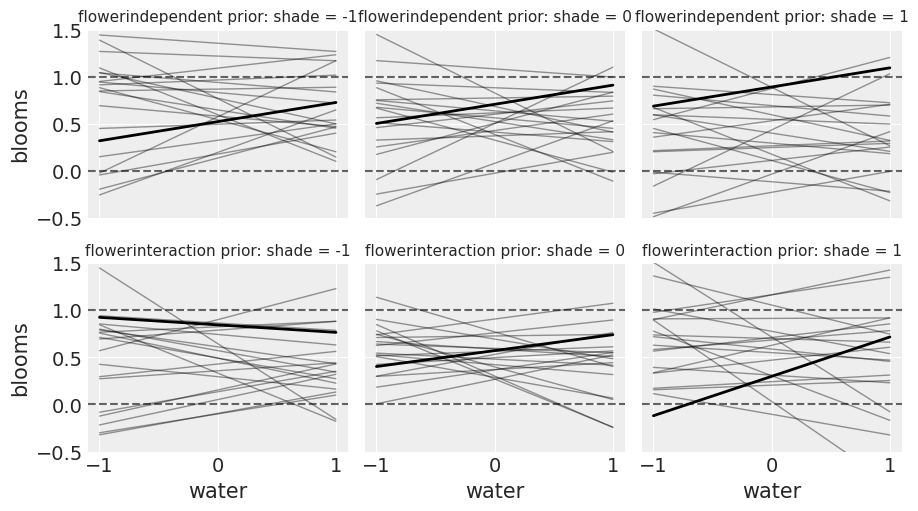

In [41]:
_, axs = plt.subplots(2, 3, figsize=[9, 5], sharey=True, sharex=True, constrained_layout=True)

n_lines = 20
pred_x = np.array([-1, 1])

for i, shade in enumerate([-1, 0, 1]):
    # top row, m_8_4
    ax = axs[0, i]
    ax.set_title(f"flowerindependent prior: shade = {shade:.0f}", fontsize=11)
    pred_y = (
       flowerindependent_priors["a"][:n_lines]
        + flowerindependent_priors["bw"][:n_lines] * pred_x.reshape(-1, 1)
        + flowerindependent_priors["bs"][:n_lines] * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))
    ax.plot(pred_x, pred_y[:, 0], lw=2, color="k")

    # bottom row, m_8_5
    ax = axs[1, i]
    ax.set_title(f"flowerinteraction prior: shade = {shade:.0f}", fontsize=11)
    pred_y = (
       flowerinteraction_priors["a"][:n_lines]
        + flowerinteraction_priors["bw"][:n_lines] * pred_x.reshape(-1, 1)
        + flowerinteraction_priors["bs"][:n_lines] * shade
        +flowerinteraction_priors["bws"][:n_lines] * pred_x.reshape(-1, 1) * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))
    ax.plot(pred_x, pred_y[:, 0], lw=2, color="k")

for ax in axs.flat:
    ax.set_ylim(-0.5, 1.5)
    ax.axhline(1, ls="dashed", color=(0, 0, 0, 0.6))
    ax.axhline(0, ls="dashed", color=(0, 0, 0, 0.6))
    if ax.is_first_col():
        ax.set_ylabel("blooms")
    if ax.is_last_row():
        ax.set_xlabel("water");

Since the lines are so scattered in the prior—the
prior not very informative—it is hard to see that the lines from the same set of samples actually
go together in meaningful ways. So I’ve bolded three lines in the top and in the bottom
rows. The three bolded lines in the top row come from the same parameter values. Notice
that all three have the same slope. This is what we expect from a model without an interaction.

So while the lines in the prior have lots of different slopes, the slopes for water don’t
depend upon shade. 

In the bottom row, the three bolded lines again come from a single prior
sample. But now the interaction makes the slope systematically change as shade changes.
What can we say about these priors, overall? They are harmless, but only weakly realistic.


Most of the lines stay within the valid outcome space. 

But silly trends are not rare. We could
do better. We could also do a lot worse, such as flat priors which would consider plausible
that even a tiny increase in shade would kill all the tulips. If you displayed these priors to your
colleagues, a reasonable summary might be, “These priors contain no bias towards positive or
negative effects, and at the same time they very weakly bound the effects to realistic ranges.”